In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stanford-image-paragraph-captioning-dataset/stanford_df_rectified.csv
/kaggle/input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images/2387936.jpg
/kaggle/input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images/2334070.jpg
/kaggle/input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images/2409937.jpg
/kaggle/input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images/2376521.jpg
/kaggle/input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images/2363057.jpg
/kaggle/input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images/2317630.jpg
/kaggle/input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images/2406500.jpg
/kaggle/input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images/2343506.jpg
/kaggle/input/stanford-image-paragraph-captioning-dataset/st

In [2]:
import os
import pandas as pd
import requests
from PIL import Image
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu

# Define original dataset paths
dataset_path = '/kaggle/input/stanford-image-paragraph-captioning-dataset/stanford_df_rectified.csv'
image_folder_path = '/kaggle/input/stanford-image-paragraph-captioning-dataset/stanford_img/content/stanford_images'

# Load dataset and cut to 2k
dataset = pd.read_csv(dataset_path)
dataset = dataset.sample(2000, random_state=42).reset_index(drop=True)
print(f"Reduced dataset size: {len(dataset)} rows")
print(dataset.head())

# List images in the original folder
image_files = [f for f in os.listdir(image_folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
print(f"Found {len(image_files)} images in {image_folder_path}")
print("Sample images:", image_files[:5])

# Define new folder for downloaded images
new_image_folder = '/kaggle/working/downloaded_images'
os.makedirs(new_image_folder, exist_ok=True)

Reduced dataset size: 2000 rows
   Image_name                                          Paragraph  train  \
0     2353881  This photograph is of buildings on a crowded s...   True   
1     2373958  The bags are on the conveyor belt at the airpo...  False   
2     2356551  Two giraffes and an antelope are in a large di...   True   
3     2318965  A man walks his dog across a rain soaked stree...   True   
4     2373308  Some zebras stand in a field. Two of them are ...   True   

    test                                                url    val  
0  False  https://cs.stanford.edu/people/rak248/VG_100K/...  False  
1   True  https://cs.stanford.edu/people/rak248/VG_100K/...  False  
2  False  https://cs.stanford.edu/people/rak248/VG_100K/...  False  
3  False  https://cs.stanford.edu/people/rak248/VG_100K/...  False  
4  False  https://cs.stanford.edu/people/rak248/VG_100K/...  False  
Found 19551 images in /kaggle/input/stanford-image-paragraph-captioning-dataset/stanford_img/content/st

In [3]:
def download_image(url, filename, output_folder):
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            image_path = os.path.join(output_folder, filename)
            with open(image_path, 'wb') as f:
                f.write(response.content)
            Image.open(image_path).convert("RGB")
            return True
        else:
            print(f"Failed to download {url} (status: {response.status_code})")
            return False
    except Exception as e:
        print(f"Error downloading {url}: {e}")
        return False

# Match images and copy to new folder
successful_images = []
dataset['image_filename'] = dataset['Image_name'].apply(lambda x: f"{x}.jpg")

for i, row in dataset.iterrows():
    filename = row['image_filename']
    original_path = os.path.join(image_folder_path, filename)
    new_path = os.path.join(new_image_folder, filename)
    
    if os.path.exists(original_path):
        try:
            Image.open(original_path).convert("RGB")
            os.system(f"cp {original_path} {new_path}")
            successful_images.append(filename)
        except Exception as e:
            print(f"Error copying {filename}: {e}")
            url = row['url']
            if download_image(url, filename, new_image_folder):
                successful_images.append(filename)
    else:
        print(f"Image {filename} not found in folder, downloading...")
        url = row['url']
        if download_image(url, filename, new_image_folder):
            successful_images.append(filename)

print(f"Successfully processed {len(successful_images)} images")
dataset = dataset[dataset['image_filename'].isin(successful_images)].reset_index(drop=True)
print(f"Final dataset size after filtering: {len(dataset)} rows")

Successfully processed 2000 images
Final dataset size after filtering: 2000 rows


In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch
from collections import Counter
import nltk
nltk.download('punkt')

# Data augmentation added
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def clean_text(text):
    return text.lower().strip()

dataset['Paragraph'] = dataset['Paragraph'].apply(clean_text)

all_captions = dataset['Paragraph'].tolist()
tokenizer = nltk.word_tokenize
word_counts = Counter()
for caption in all_captions:
    word_counts.update(tokenizer(caption))

# Lowered threshold to 3
vocab = ['<PAD>', '<START>', '<END>', '<UNK>'] + [word for word, count in word_counts.items() if count >= 3]
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

def caption_to_sequence(caption):
    tokens = tokenizer(caption)
    seq = [word2idx.get(token, word2idx['<UNK>']) for token in tokens]
    return [word2idx['<START>']] + seq + [word2idx['<END>']]

class ImageCaptionDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = os.path.join(self.image_folder, row['image_filename'])
        try:
            image = Image.open(image_path).convert("RGB")
            caption = row['Paragraph']
            if self.transform:
                image = self.transform(image)
            caption_seq = caption_to_sequence(caption)
            return image, torch.tensor(caption_seq)
        except Exception as e:
            print(f"Error loading {image_path}: {e}")
            return None, None

train_data = dataset[dataset['train'] == 1]
val_data = dataset[dataset['val'] == 1]
test_data = dataset[dataset['test'] == 1]

batch_size = 8  # Reduced for stability
train_dataset = ImageCaptionDataset(train_data, new_image_folder, image_transform)
val_dataset = ImageCaptionDataset(val_data, new_image_folder, image_transform)
test_dataset = ImageCaptionDataset(test_data, new_image_folder, image_transform)

def collate_fn(batch):
    batch = [b for b in batch if b[0] is not None]
    if len(batch) == 0:
        return None
    images, captions = zip(*batch)
    images = torch.stack(images)
    captions = torch.nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=word2idx['<PAD>'])
    return images, captions

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Vocabulary size: 2077


In [5]:
import torch.nn as nn

class CNNLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1):
        super(CNNLSTMModel, self).__init__()
        self.cnn = models.resnet50(pretrained=True)
        self.cnn.fc = nn.Identity()
        for param in self.cnn.parameters():
            param.requires_grad = False  # Frozen initially
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size + 2048, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, images, captions):
        features = self.cnn(images)
        features = features.unsqueeze(1).repeat(1, captions.size(1), 1)
        embeddings = self.embed(captions)
        inputs = torch.cat((features, embeddings), dim=2)
        outputs, _ = self.lstm(inputs)
        outputs = self.fc(outputs)
        return outputs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNLSTMModel(vocab_size).to(device)
print("Model loaded on:", device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 150MB/s]


Model loaded on: cpu


In [6]:
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<PAD>'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)  # Gentler decay

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10  # Increased to 10
output_dir = '/kaggle/working/checkpoints'
os.makedirs(output_dir, exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} - Training"):
        if batch is None:
            continue
        images, captions = batch
        images, captions = images.to(device), captions.to(device)
        
        outputs = model(images, captions[:, :-1])
        loss = criterion(outputs.reshape(-1, vocab_size), captions[:, 1:].reshape(-1))
        train_loss += loss.item()
        
        preds = outputs.argmax(dim=2)
        mask = captions[:, 1:] != word2idx['<PAD>']
        train_correct += (preds[mask] == captions[:, 1:][mask]).sum().item()
        train_total += mask.sum().item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = train_correct / train_total if train_total > 0 else 0
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    torch.save(model.state_dict(), os.path.join(output_dir, f'model_epoch_{epoch+1}.pt'))

    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} - Validation"):
            if batch is None:
                continue
            images, captions = batch
            images, captions = images.to(device), captions.to(device)
            outputs = model(images, captions[:, :-1])
            loss = criterion(outputs.reshape(-1, vocab_size), captions[:, 1:].reshape(-1))
            val_loss += loss.item()
            
            preds = outputs.argmax(dim=2)
            mask = captions[:, 1:] != word2idx['<PAD>']
            val_correct += (preds[mask] == captions[:, 1:][mask]).sum().item()
            val_total += mask.sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total if val_total > 0 else 0
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    scheduler.step()
    if epoch > 1 and val_losses[-1] > val_losses[-2]:
        print("Early stopping triggered")
        break

Epoch 1 - Training: 100%|██████████| 192/192 [05:09<00:00,  1.61s/it]


Epoch 1, Train Loss: 4.7235, Train Accuracy: 0.2091


Epoch 1 - Validation: 100%|██████████| 31/31 [00:37<00:00,  1.20s/it]


Epoch 1, Val Loss: 4.2446, Val Accuracy: 0.2663


Epoch 2 - Training: 100%|██████████| 192/192 [05:10<00:00,  1.62s/it]


Epoch 2, Train Loss: 4.0440, Train Accuracy: 0.2821


Epoch 2 - Validation: 100%|██████████| 31/31 [00:38<00:00,  1.23s/it]


Epoch 2, Val Loss: 3.9464, Val Accuracy: 0.2986


Epoch 3 - Training: 100%|██████████| 192/192 [05:10<00:00,  1.62s/it]


Epoch 3, Train Loss: 3.8042, Train Accuracy: 0.3014


Epoch 3 - Validation: 100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


Epoch 3, Val Loss: 3.7985, Val Accuracy: 0.3075


Epoch 4 - Training: 100%|██████████| 192/192 [05:10<00:00,  1.62s/it]


Epoch 4, Train Loss: 3.6389, Train Accuracy: 0.3142


Epoch 4 - Validation: 100%|██████████| 31/31 [00:37<00:00,  1.20s/it]


Epoch 4, Val Loss: 3.7091, Val Accuracy: 0.3099


Epoch 5 - Training: 100%|██████████| 192/192 [05:09<00:00,  1.61s/it]


Epoch 5, Train Loss: 3.5193, Train Accuracy: 0.3248


Epoch 5 - Validation: 100%|██████████| 31/31 [00:38<00:00,  1.25s/it]


Epoch 5, Val Loss: 3.6392, Val Accuracy: 0.3163


Epoch 6 - Training: 100%|██████████| 192/192 [05:09<00:00,  1.61s/it]


Epoch 6, Train Loss: 3.4317, Train Accuracy: 0.3326


Epoch 6 - Validation: 100%|██████████| 31/31 [00:37<00:00,  1.20s/it]


Epoch 6, Val Loss: 3.5772, Val Accuracy: 0.3235


Epoch 7 - Training: 100%|██████████| 192/192 [05:12<00:00,  1.63s/it]


Epoch 7, Train Loss: 3.3536, Train Accuracy: 0.3384


Epoch 7 - Validation: 100%|██████████| 31/31 [00:37<00:00,  1.20s/it]


Epoch 7, Val Loss: 3.5325, Val Accuracy: 0.3259


Epoch 8 - Training: 100%|██████████| 192/192 [05:10<00:00,  1.62s/it]


Epoch 8, Train Loss: 3.2913, Train Accuracy: 0.3451


Epoch 8 - Validation: 100%|██████████| 31/31 [00:38<00:00,  1.23s/it]


Epoch 8, Val Loss: 3.4922, Val Accuracy: 0.3313


Epoch 9 - Training: 100%|██████████| 192/192 [05:10<00:00,  1.62s/it]


Epoch 9, Train Loss: 3.2340, Train Accuracy: 0.3502


Epoch 9 - Validation: 100%|██████████| 31/31 [00:37<00:00,  1.20s/it]


Epoch 9, Val Loss: 3.4673, Val Accuracy: 0.3318


Epoch 10 - Training: 100%|██████████| 192/192 [05:10<00:00,  1.62s/it]


Epoch 10, Train Loss: 3.1890, Train Accuracy: 0.3548


Epoch 10 - Validation: 100%|██████████| 31/31 [00:39<00:00,  1.27s/it]

Epoch 10, Val Loss: 3.4376, Val Accuracy: 0.3341


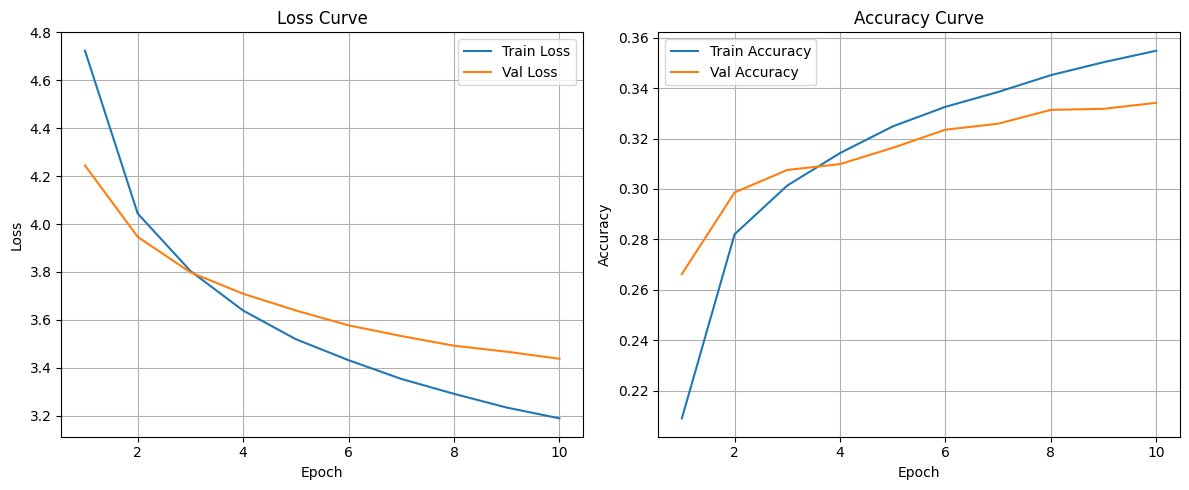

Curves saved to /kaggle/working/loss_accuracy_curves.png


In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('/kaggle/working/loss_accuracy_curves.png')
plt.show()
print("Curves saved to /kaggle/working/loss_accuracy_curves.png")

In [8]:
from tqdm import tqdm

def beam_search_caption(model, image, beam_width=3, max_length=20):
    model.eval()
    with torch.no_grad():
        features = model.cnn(image.unsqueeze(0).to(device))  # [1, 2048]
        features = features.unsqueeze(1)  # [1, 1, 2048]
        
        # Initialize beam
        start_token = word2idx['<START>']
        beams = [(torch.tensor([start_token]).to(device), 0.0)]  # (sequence, log_prob)
        
        for _ in range(max_length):
            new_beams = []
            for seq, score in beams:
                if seq[-1].item() == word2idx['<END>']:
                    new_beams.append((seq, score))
                    continue
                
                seq_tensor = seq.unsqueeze(0)  # [1, seq_len]
                embeddings = model.embed(seq_tensor)  # [1, seq_len, embed_size]
                features_repeated = features.repeat(1, embeddings.size(1), 1)  # [1, seq_len, 2048]
                inputs = torch.cat((features_repeated, embeddings), dim=2)  # [1, seq_len, 2304]
                outputs, _ = model.lstm(inputs)  # [1, seq_len, hidden_size]
                logits = model.fc(outputs[:, -1, :])  # [1, vocab_size]
                probs = torch.log_softmax(logits, dim=-1)  # [1, vocab_size]
                
                top_probs, top_words = probs.topk(beam_width, dim=1)
                for i in range(beam_width):
                    new_seq = torch.cat((seq, top_words[0, i].unsqueeze(0)))
                    new_score = score + top_probs[0, i].item()
                    new_beams.append((new_seq, new_score))
            
            # Keep top beam_width sequences
            beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]
            if all(seq[-1].item() == word2idx['<END>'] for seq, _ in beams):
                break
        
        # Return the best sequence
        best_seq = beams[0][0]
        return ' '.join([idx2word[idx.item()] for idx in best_seq[1:] if idx.item() != word2idx['<END>']])

# Debug: Check feature diversity
def check_feature_diversity(model, test_loader):
    model.eval()
    features_list = []
    with torch.no_grad():
        for images, _ in test_loader:
            if images is None:
                continue
            images = images.to(device)
            for i in range(images.size(0)):
                features = model.cnn(images[i].unsqueeze(0)).cpu()
                features_list.append(features)
            break  # Check only first batch
    print("Feature diversity check (first few images):")
    for i, feat in enumerate(features_list[:3]):
        print(f"Image {i} feature norm: {feat.norm().item():.4f}")

check_feature_diversity(model, test_loader)

generated_captions = []
original_captions = []
bleu_scores = []

for images, captions in tqdm(test_loader, desc="Generating Captions"):
    if images is None:
        continue
    images = images.to(device)
    for i in range(images.size(0)):
        gen_caption = beam_search_caption(model, images[i])
        orig_caption = ' '.join([idx2word[idx.item()] for idx in captions[i] if idx.item() not in [word2idx['<START>'], word2idx['<END>'], word2idx['<PAD>']]])
        generated_captions.append(gen_caption)
        original_captions.append(orig_caption)
        
        gen_tokens = tokenizer(gen_caption)
        orig_tokens = tokenizer(orig_caption)
        bleu = sentence_bleu([orig_tokens], gen_tokens, weights=(1, 0, 0, 0))
        bleu_scores.append(bleu)

total_prediction_percentage = sum(bleu_scores) / len(bleu_scores) * 100
print(f"Total Prediction Percentage (BLEU-1): {total_prediction_percentage:.2f}%")

test_data = test_data.copy()
test_data['Generated_Caption'] = pd.Series(generated_captions[:len(test_data)])
test_data['Original_Caption'] = pd.Series(original_captions[:len(test_data)])
test_data['BLEU_Score'] = pd.Series(bleu_scores[:len(test_data)])
test_data.to_csv('/kaggle/working/test_results.csv', index=False)
print("Results saved to /kaggle/working/test_results.csv")

print("\nSample Results:")
for i in range(min(5, len(test_data))):
    print(f"Image: {test_data['image_filename'].iloc[i]}")
    print(f"Original: {test_data['Original_Caption'].iloc[i]}")
    print(f"Generated: {test_data['Generated_Caption'].iloc[i]}")
    print(f"BLEU-1: {test_data['BLEU_Score'].iloc[i]:.4f}\n")

Feature diversity check (first few images):
Image 0 feature norm: 29.4119
Image 1 feature norm: 25.9212
Image 2 feature norm: 25.1083


Generating Captions:   0%|          | 0/29 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
Generating Captions:  21%|██        | 6/29 [00:24<01:34,  4.10s/it]/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
Generating Captions: 100%|██████████| 29/29 [01:57<00:00,  4.04s/it]

Total Prediction Percentage (BLEU-1): 9.26%
Results saved to /kaggle/working/test_results.csv

Sample Results:
Image: 2373958.jpg
Original: a large truck has a blue <UNK> and a red container attached to the back of it . it is sitting on a parking lot that 's surrounded by leafless trees . the sky is blue and it is sunny . there is shadow on the ground near the truck .
Generated: a man is wearing a black shirt . there is a large building in front of the street . there
BLEU-1: 0.1056

Image: 2366968.jpg
Original: this is a photo of a dessert . the dessert is a cake that is <UNK> and white and is sliced into <UNK> . the brown slices are chocolate and are powdered . the white slices are sugar powdered . the cake is on a white plate . the table under the plate is white and plain as well . there are <UNK> of brown <UNK> on the cake on the edge of the plate .
Generated: there is a <UNK> of food on the table . there is a <UNK> on the table . there is
BLEU-1: 0.0684

Image: 2383287.jpg
Original